# Cross-resonance gate between 2 transmons: linear approximation

In [32]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem, Qubit
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from matplotlib.colors import LogNorm
from pysqkit.util.hsbasis import weyl_by_index
import qutip
import itertools
from functools import partial
import multiprocessing
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
#import util_cr as util
import copy
import json
import cmath

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_{T, 1} + H^{(0)}_{T, 2} + V + H_{drive},$$

$$H^{(0)}_{T, k} =  \hbar \omega_{T, k} b_k^{\dagger}b_k + \hbar \frac{\delta_{T, k}}{2} b_k^{\dagger} b_k^{\dagger}b_k b_k,$$

$$V = J_C q_{T1} q_{T2},$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_{T1} q_{T1} + \varepsilon_{T2} q_{T2} \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
q_{Tk} = i \biggl( \frac{E_{J,k}}{32 |\delta_{T,k} |} \biggr)^{1/4} (b_k^{\dagger} - b_k) = i q_{ZPF} (b_k^{\dagger} - b_k),
$$
where 
$$
E_{J, k} = \hbar \biggl(\frac{\omega_{T, k} - \delta_{T, k}}{8 | \delta_{T, k} |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $Z X$ term in the Hamiltonian. In particular, we will explore the idea of driving the fluxonium at the transmon frequency. The opposite idea to drive the transmon at the fluxonium frequency does not seem that promising. However, one might evaluate using Raman transitions.

# Introducing the qubits and the coupled system

In [33]:
with open('flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [34]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "3"

control_freq = 5.0

#Transmon
levels_t = 3
transm_t = pysqkit.qubits.SimpleTransmon(
    label='T1', 
    max_freq=control_freq - 0.05, 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set[p_set]["dephasing_times_t"]
)


transm_c = pysqkit.qubits.SimpleTransmon(
    label='T2', 
    max_freq=control_freq, 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set[p_set]["dephasing_times_t"]
)


# We also add a drive on the fluxonium
transm_c.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_c',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_t - d_comp

jc = 0.002 #play to get similar ZZ
# jc = 0.0010 #play to get similar ZZ
coupled_sys = transm_t.couple_to(transm_c, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)

In [35]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

The basis principle behind the gate is illustrated in the following figure

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. 
We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\mu_{YZ} = \lvert \langle 10 | q_{F} | 00 \rangle - \langle 11 | q_{F} |01 \rangle \rvert $$
$$\mu_{Y} = \lvert \langle 10 | q_{F} | 00 \rangle + \langle 11 | q_{F} |01 \rangle \rvert $$

The second term quantifies the gate speed. Notice that if the phase of the drive is $0$ one hase a $YZ$ term from the charge operator. 

For the given parameters we have

In [36]:
def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def mu_yz_control(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_control(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [37]:
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*zz(coupled_sys))))
q_op = coupled_sys["T2"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_control(comp_states, q_op))))
display(Latex(r'$\mu_{{IY}} = {:.4f} $'.format(mu_yi_control(comp_states, q_op))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [38]:
freq_drive = transm_t.max_freq
eps_drive = 0.030

In [43]:
def cr_gate_time(
    cr_coeff: float
):
    return 1/(2*np.pi*cr_coeff)*np.pi/4

def cr_effect_sw(
    jc: float,
    eps_drive: float,
    transm_t: Qubit,
    transm_c: Qubit
) -> float:
    """
    Description
    ---------------------------------------------------------------------
    Returns the cross-resonance coefficient in the linear approximation
    using the result of Magesan-Gambetta
    """
    j_eff = jc*transm_c.charge_zpf*transm_t.charge_zpf
    delta_t = transm_t.anharm
    delta_c = transm_c.anharm
    detuning = transm_c.freq - transm_t.freq
    return j_eff*transm_c.charge_zpf*eps_drive/detuning*(delta_c/(delta_c + detuning))/2

In [44]:
mu_cr_sw = cr_effect_sw(jc, eps_drive, transm_t, transm_c)*1e3
print(mu_cr_sw)

0.8314309013682397


In [45]:
mu_cr = mu_yz_control(comp_states, coupled_sys['T2'].charge_op())*eps_drive*1e3/2
print(mu_cr)

-0.8290984733030443


In [46]:
cr_gate_time(mu_cr_sw/1e3)

150.34322129992333

# Generating data

In [82]:
def get_cr_effect(
    freq: float,
    eps: float,
    jc: float,
    transm_c: Qubit,
):
    """
    Description
    -----------------------------------------------------------------------
    Returns the exact cross-resonance coefficient in MHz.
    """
    
    freq 
    
    transm_t = pysqkit.qubits.SimpleTransmon(
            label='T_tmp', 
            max_freq=freq, 
            anharm=transm_c.anharm,
            dim_hilbert=transm_c.dim_hilbert,
        )
    
    eps_ratio = eps*transm_c.charge_zpf/np.abs(freq - (transm_c.max_freq + transm_c.anharm))
    
    freq_drive = freq
    
    coupled_sys = transm_t.couple_to(transm_c, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    
    state_label = ["00", "01", "10", "11"]
    comp_states = {}
    for label in state_label:
        state_tmp = coupled_sys.state(label)[1]
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states[label] = state_tmp
    
    mu_cr = mu_yz_control(comp_states, coupled_sys['T2'].charge_op())*eps*1e3
    
    mu_cr_sw = cr_effect_sw(jc, eps, transm_t, transm_c)*1e3
    
    zz_coeff = zz(coupled_sys)*1e3
    
    output = {}
    output["freq_fixed"] = transm_t.freq
    output["freq"] = freq
    output["eps"] = eps
    output["eps_ratio"] = eps_ratio
    output["cr"] = np.abs(mu_cr)
    output["cr_sw"] = np.abs(mu_cr_sw)
    output["zz"] = zz_coeff
    output["gate_time"] = cr_gate_time(np.abs(mu_cr/1e3))
    output["gate_time_sw"] = cr_gate_time(np.abs(mu_cr_sw/1e3))
    
    output["jc"] = jc*1e3
    
    return output

func = partial(get_cr_effect, eps=0.03, jc=jc, transm_c=transm_c)
    
func(4.9)

{'freq_fixed': 4.9,
 'freq': 4.9,
 'eps': 0.03,
 'eps_ratio': 0.157619002661481,
 'cr': 1.0333094480935043,
 'cr_sw': 1.0343277934847364,
 'zz': 0.0716855244338177,
 'gate_time': 241.94107627803038,
 'gate_time_sw': 241.7028736680557,
 'jc': 2.0}

In [83]:
delta_freq = 0.8
n_points = 200
freq_list = list(np.linspace(transm_c.freq - delta_freq, transm_c.freq + delta_freq, n_points))

n_process = 4

start = time.time()

pool = multiprocessing.Pool(processes=n_process)

result = pool.map(func, freq_list)

pool.close()
pool.join()

end = time.time()

print("Computation time = {} s".format(end - start))



Computation time = 0.6254901885986328 s


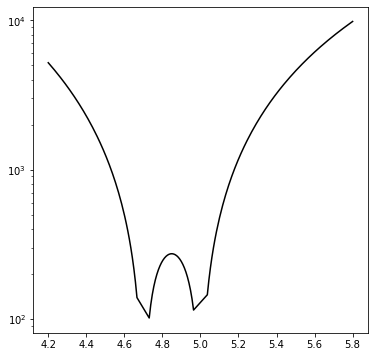

In [84]:
def plot_cr(
    result: list,
    transm_c: Qubit,
    opt={'fs': 24, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16, 'fsl':20},
    save=False
):
    bound_1 = 0.03
    bound_2 = 0.03
    freq_list = []
    gate_times = []
    for res in result:
        freq = res["freq"]
        condition_1 = np.abs((freq - (transm_c.freq + transm_c.anharm))) > bound_1
        condition_2 = np.abs((freq - (transm_c.freq))) > bound_2
        if condition_1 and condition_2:
                freq_list.append(freq)
                gate_times.append(res["gate_time_sw"])

    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.semilogy(freq_list, gate_times, linestyle='-',
                color="black")
    #ax.set_ylim([100, 1000])
    #ax.legend(loc='best', fontsize=opt["fs"])
    plt.show()
            
    
plot_cr(result, transm_c)
    
    

In [85]:
save = True
if save:
    with open('tmp/data_cr_transmon_transmon_linear.txt', 'w') as fp:
        json.dump(result, fp)